# 텍스트 생성 방법 : Transformers를 이용한 언어생성에 서로 다른 디코딩 방법 사용

#소개
최근 몇 년 동안, OpenAI의 유명한 모델 GPT2처럼 수백만 개의 웹 페이지에서 훈련된 Transformer 기반 대형 언어 모델의 등장으로 개방형 언어 생성에 대한 관심이 증가하고 있습니다. 개선된 Transformer 아키텍처와 대규모 unsupervised training data 외에도, 더 나은 Decoding 방법도 중요한 역할을 했습니다.

이 실습 자료는 다양한 Decoding 전략에 대한 간략한 개요를 제공합니다.

다음 모든 기능은 auto-regressive 언어 생성에 사용할 수 있습니다. 요약하자면, auto-regressive 언어 생성은 word sequence의 확률 분포가 다음 던어 분포에 관한 P식의 결과로 분해될 수 있고

$$ P(w_{1:T} | W_0 ) = \prod_{t=1}^T P(w_{t} | w_{1: t-1}, W_0) \text{ ,with }  w_{1: 0} = \emptyset, $$

W0가 초기 Context word sequence의 결과로 분해될 수 있다는 가정에 기초합니다.

Word sequence의 길이 T는 보통 즉시 결정되며, P식에서 EOS 토큰이 생성된 timestep t=T와 부합합니다.

이번 실습에서는 가장 두드러진 decoding 방법으로 Greedy search, Beam search, Top-K sampling, Top-p sampling을 주로 둘러볼 것입니다.



Auto-regressive 언어 생성은 이전에 생성된 단어들을 기반으로 다음 단어를 예측하는 방식으로 텍스트를 생성하는 방법을 의미

Transformers를 설치하고 Model을 load하겠습니다.

In [ ]:
!pip install transformers

이번 실습을 위해 SKT에서 공개한 KoGPT-2 모델을 사용해보도록 하겠습니다 :-)

In [ ]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!apt-get install git-lfs
!git lfs install
!git clone https://huggingface.co/taeminlee/kogpt2

Detected operating system as Ubuntu/jammy.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Detected apt version as 2.4.13
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... Packagecloud gpg key imported to /etc/apt/keyrings/github_git-lfs-archive-keyring.gpg
done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages will be upgraded:
  git-lfs
1 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Need to get 8,489 kB of archives.
After this operation, 7,671 kB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu jammy/main amd64 git-lfs amd64 3.6.1 [8,489 kB]
Fetched 8,489 kB in 0s (30.6 MB/s)
(Reading database ... 124930 files and directories c

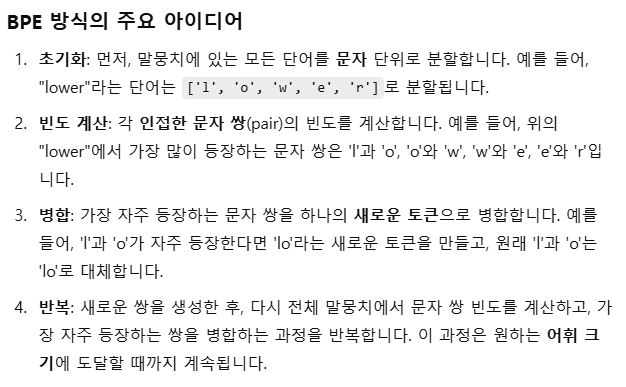

In [ ]:
import torch
from tokenizers import SentencePieceBPETokenizer
from transformers import GPT2Config, GPT2LMHeadModel

# SentencePieceBPETokenizer는 vocab.json과 merges.txt 파일을 사용하여 BPE(Byte Pair Encoding) 방식의 토크나이저를 설정 (GPT-2 모델의 사전 학습에 사용된 토크나이저)
# BPE(Byte Pair Encoding) 방식은 자연어 처리에서 단어를 서브워드(subword) 단위로 분할하는 방식 중 하나로, 주로 어휘 크기 축소와 미지의 단어 처리를 위해 사용
# vocab.json은 어휘 집합을 담고 있고, merges.txt는 BPE 병합 규칙을 담고 있다.
tokenizer = SentencePieceBPETokenizer("/content/kogpt2/vocab.json", "/content/kogpt2/merges.txt")

# GPT2Config를 사용하여 모델 설정을 초기화합니다. 여기서 vocab_size=50000은 어휘 집합의 크기를 50,000으로 설정
config = GPT2Config(vocab_size=50000)
config.pad_token_id = tokenizer.token_to_id('<pad>')
model = GPT2LMHeadModel(config)

# /content/kogpt2/pytorch_model.bin 경로에서 학습된 모델 가중치를 로드
model_dir = '/content/kogpt2/pytorch_model.bin'

model.load_state_dict(torch.load(model_dir, map_location='cuda'), strict=False)
model.to('cuda')

<ipython-input-3-82446dae5b71>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_dir, map_location='cuda'), strict=False)


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50000, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50000, bias=False)
)

### **Greedy Search**

Greedy search는 단순히 가장 높은 확률을 가진 단어를 다음 단어로 선택합니다.   
$w_t = argmax_{w}P(w | w_{1:t-1})$ 는 각각의 timestep $t$ 입니다. 아래 그림은 greedy search을 보여줍니다.   

![Greedy Search](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/greedy_search.png)

알고리즘은 단어 "The"에서 시작하여 다음 단어로 가장 높은 확률의 단어인 "nice" 등을 선택하는 탐욕법입니다. 그러므로 최종적으로 생성된 Word sequence는 "The", "nice", "woman"이며 전반적인 확률은 0.5x0.4 = 0.2로 계산됩니다.

다음 문맥 ("I", "enjoy", "walking", "with", "my", "cute", "dog")에서 GPT2를 사용하여 Word sequence를 생성할 수 있습니다.

Transformers에서 다음과 같은 greedy search를 사용하는 방법을 살펴보겠습니다.





In [ ]:
# encode context the generation is conditioned on
# 입력된 텍스트를 토크나이저를 이용해 토큰화
# tokenizer.encode를 사용하여 정수 인덱스 리스트로 변환. add_special_tokens=False는 텍스트에 [CLS], [SEP]와 같은 특별한 토큰을 추가하지 않겠다는 의미
def tokenizing(text):
    return torch.tensor(tokenizer.encode(text, add_special_tokens=False).ids).unsqueeze(0).to('cuda')


input_ids = tokenizing("이순신은 조선 중기의 무신이다.")

# generate text until the output length (which includes the context length) reaches 100
# 생성 모델은 generate 함수를 통해 다음 token을 생성해낼 수 있다.
# 그리디 탐색 방식을 사용하여 다음 단어를 예측 -> 모델은 단어를 하나씩 생성하면서 그 이전에 생성된 단어들을 컨텍스트로 포함하여 다음 단어를 만든다.
greedy_output = model.generate(input_ids, max_length=100)

print("Output:\n" + 100 * '-')

# tokenizer.decode(greedy_output.tolist()[0], skip_special_tokens=True)는 생성된 토큰을 다시 텍스트로 변환
# skip_special_tokens=True는 [PAD], [CLS], [SEP]와 같은 특별한 토큰을 출력에서 제외
print(tokenizer.decode(greedy_output.tolist()[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
이순신은 조선 중기의 무신이다.</s><s> 이 때문에, 이 목록은 다음과 같다.</s><s> 이 목록은 다음과 같다.</s><s> 이 목록은 다음과 같다.</s><s> 이 목록은 다음과 같다.</s><s> 이 목록은 다음과 같다.</s><s> 이 목록은 다음과 같다.</s><s> 이 목록은 다음과 같다.</s><s> 이 목록은 다음과 같다.</s><s> 이 목록은 다음과 같다.</s><s> 이 목록은 다음과 같다.</s><s> 이 목록은 다음과 같다.</s><s> 이 목록은 다음과 같다.</s><s> 이 목록은 다음과 같다


GPT2로 짧은 텍스트를 생성했습니다.   
생성된 단어 문맥은 합리적이지만 모델은 비슷한 단어를 반복하는 수준입니다.   
이러한 현상은 일반적인 언어생성 모델에서 나타나는 공통된 문제이며 특히 Greedy search와 Beam search에서 훨씬 더 그런 현상이 두드러져 보입니다. (Vijayakumar et al., 2016 and Shao et al., 2017에서 관련 내용을 확인 할 수 있습니다.)   

Greedy search의 주요 단점은 그림에서 볼수 있듯이 낮은 확률 단어 이후에 나올수 있는 더 높은 확률의 단어를 놓친다는 점입니다.

예를 들면 단어 "has"는 0.9의 높은 조건부 확률을 가지고 있지만, 첫 검색단어중 두번째로 높은 조건부 확률 단어인 "dog" 이후에  숨어있는 형태입니다. 따라서 Greedy search는 "The","dog","has"라는 Word sequence를 놓치게 됩니다.

이러한 문제는 Beam search에서 완화할 수 있습니다.

### **Beam search**

Beam search는 각 Time step에서 가장 확률이 높은 Hypotheses의 num_beams를 유지하고 결국 전체 확률이 가장 높은 hypothesis를 선택하는 것으로 숨겨진 높은 확률 Word sequence를 놓칠 위험을 줄입니다.

`num_beams =2`라고 가정하고 Toy example을 설명하겠습니다.

![Beam search](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/beam_search.png)

Time step=1일때, Beam search는 가장 가능성 높은 Hypothesis "The","nice"외에도 두번째로 가능성 높은 Hypothesis인 "The","dog"를 추적합니다.

Time step=2일때, Beam search는 Word sequence 확률 0.2를 가진 ("The","nice","woman") 보다 확률 0.36을 가진 ("The", "dog", "has")가 높다는 것을 찾습니다. 이것으로 Toy example에서 가장 가능성 높은 Word sequence를 발견 할 수 있다는 것을 보였습니다.

Beam search는 항상 Greedy search보다 높은 확률의 결과 Sequence를 찾는 것이 가능합니다. 그러나 이것이 가장 가능성 높은 결과를 찾은 것이라고는 보장할 수 없습니다.

`transformers`에서 Beam search를 사용하는 방법을 살펴볼 것입니다. 모든 Beam Hypotheses가 EOS토큰에 닿으면 생성이 완료되도록 `num_beams > 1` 과 `eqrly_stopping=True`로 파라미터를 설정합니다.


In [ ]:
# activate beam search and early_stopping
beam_output = model.generate(
    input_ids,
    max_length=50,
    num_beams=5,    # num_beams=5는 5개의 후보 텍스트를 동시에 고려하여 가장 확률이 높은 텍스트를 선택
    early_stopping=True # 보통 모델이 생성한 텍스트가 일정 기준을 넘어서면 더 이상 생성할 필요가 없다고 판단하여 더 빠르게 텍스트 생성을 멈춤.
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output.tolist()[0], skip_special_tokens=True))


Output:
----------------------------------------------------------------------------------------------------
이순신은 조선 중기의 무신이다.</s><s> 그 후, 이조참의(吏曹參議)가 되었다.</s><s> 이조참의(吏曹參議)가 되었다.</s><s> 이조참의(吏曹參議)가


결과는 틀림없이 더 유창하게 보이지만 여전히 동일한 Word sequence를 반복하는 문제를 포함합니다.

단순한 해결법은 Paulus et al. (2017)과 Klein et al. (2017)의 논문에서 제안된 n-grams 패널티를 도입하는 것입니다. 가장 일반적인 n-grams 패널티는 이미 나타난 n-gram에 대해 다음 단어로 생성될 확률을 0으로 설정하여 두번 나타나지 않도록 하는 방법입니다.

`no_repeat_ngram_size=2`을 설정한다면 2-gram이 두번 나타나는 것을 막을 수 있습니다.

In [ ]:
# set no_repeat_ngram_size to 2
beam_output = model.generate(
    input_ids,
    max_length=50,
    num_beams=5,    # num_beams=5는 5개의 후보 텍스트를 동시에 고려하여 가장 확률이 높은 텍스트를 선택
    no_repeat_ngram_size=2, # n-gram 패널티 설정, 2-gram을 설정하여 생성된 텍스트에서 같은 2-gram (연속된 두 단어)이 반복되지 않도록 함.
                            # 예를 들어, "조선"과 "중기"가 반복되지 않도록 패널티를 적용
    early_stopping=True
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output.tolist()[0], skip_special_tokens=True))


Output:
----------------------------------------------------------------------------------------------------
이순신은 조선 중기의 무신이다.</s><s> 이 목록은 대한민국의 음악 목록에서 쓰이는 모든 곡들을 나열한 것이다.<ref name="font"></a></ref></td> </tr></table> <p><a href="


더이상 반복이 나타나지 않는 다는 것을 볼 수 있습니다. 하지만 n-gram 패널티는 신중하게 사용되어야 합니다. 예를 들면 city New York에 대해 생성된 기사는 n-gram을 사용하지 않는 것이 좋습니다. 2-gram을 사용하게 될 경우 시의 이름이 전체 텍스트에서 한 번만 나타나기 때문입니다.

Beam search의 또 다른 중요한 특징은 생성된 Top beam을 비교하여 목적에 가장 적합한 Beam을 선택할 수 있다는 것입니다.

Transformer에서 num_return_sequences 파라미터를 return 해야 하는 최대 num_beams 보다 작거나 같도록 설정합니다. `num_return_sequences <= num_beams`로 설정된 코드를 확인할 수 있습니다.

In [ ]:
# set return_num_sequences > 1
beam_outputs = model.generate(
    input_ids,
    max_length=50,
    num_beams=5,
    no_repeat_ngram_size=2,
    num_return_sequences=5, # 생성할 시퀀스의 개수를 5개로 설정. 즉, 모델은 5개의 다른 텍스트 시퀀스를 생성하여 반환
    early_stopping=True
)

# now we have 5 output sequences
print("Output:\n" + 100 * '-')
for i, beam_output in enumerate(beam_outputs):
  print("{}: {}".format(i, tokenizer.decode(beam_output.tolist(), skip_special_tokens=True)))

Output:
----------------------------------------------------------------------------------------------------
0: 이순신은 조선 중기의 무신이다.</s><s> 그 후, 그 해 12월 16일(음력 4월 15일)에 향년 60세를 일기로 타계하였다. &lt;삼국사기&gt;(三國史記)에는
1: 이순신은 조선 중기의 무신이다.</s><s> 그 후, 그 해 12월 16일(음력 4월 15일)에 향년 60세를 일기로 타계하였다. &lt;삼국사기&gt;(三國史記)의
2: 이순신은 조선 중기의 무신이다.</s><s> 그 후, 그 해 12월 16일(음력 4월 15일)에 향년 60세를 일기로 타계하였다. &lt;삼국사기&gt;(三國史記)는
3: 이순신은 조선 중기의 무신이다.</s><s> 그 후, 그 해 12월 16일(음력 4월 15일)에 향년 60세를 일기로 타계하였다. &lt;삼국사기&gt;(三國史記)에서
4: 이순신은 조선 중기의 무신이다.</s><s> 그 후, 그 해 12월 16일(음력 4월 15일)에 향년 60세를 일기로 타계하였다. &lt;삼국사기&gt;(三國史記)에서는


코드 결과를 통해 볼수 있듯이 5개의 Beam hypotheses는 서로 약간 다를 뿐이며 5개만 사용했을 경우 놀랄만한 결과는 아닙니다.

개방형 생성에서는 Beam search가 최선의 선택사항이 아닐수 있는 몇 가지 이유가 최근에 제시되었습니다.

- Beam search는 Machine translation 또는 Text summarization처럼 원하는 문장 생성 길이가 예측 가능한 Task에서는 잘 작동할 수 있습니다. 하지만 Dialog 또는 Story Generation Task처럼 출력길이가 크게 달라질 수 있는 개방형 생성에서는 원활하게 작동하지 않습니다. (
[Murray et al. (2018)](https://arxiv.org/abs/1808.10006), [Yang et al. (2018)](https://arxiv.org/abs/1808.09582))

- Beam search은 반복 생성 문제에 취약합니다. 특히 Story Generation Task에서 n-gram또는 기타 패널티를 통해 문장을 제어하는 것이 어렵습니다. 왜냐하면 "반복이 없는 구문"과 "n=gram반복 주기" 사이에서 적당한 trade-off를 찾기 위해 많은 finetuning이 필요하기 때문입니다.

- [Ari Holtzman et al. (2019)](https://arxiv.org/abs/1904.09751) 논문에 따르면 고품질 인간 언어는 높은 확률의 다음 단어 분포를 따르지 않는다고 주장합니다. 쉽게 말하자면 인간입장에서 우리는 지루하거나 예측 가능한 문장이 아니라 우리를 놀라게 할 수 있는 문장생성을 원한다고 합니다. 저자는 모델이 인간 텍스트 대비 beam search text를 그래프로 보여주면서 beam search text가 그다지 놀랍지 않은 문장이라는 것을 보여줬습니다.


![alt text](https://blog.fastforwardlabs.com/images/2019/05/Screen_Shot_2019_05_08_at_3_06_36_PM-1557342561886.png)

### **Sampling**

가장 기본적인 형태의 Sampling은 조건부 확률 분포에 따라 다음 단어 $w_t$를 무작위로 선택하는 것을 의미합니다.


$$w_t \sim P(w|w_{1:t-1})$$

위의 예를 들어, 아래 사진은 Sampling할 때 언어 생성을 시각화한 형태입니다.


![vanilla_sampling](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/sampling_search.png)


Sampling을 이용한 언어생성은 더이상 결정론적이지 않습니다. 단어
$\text{"car"}$ 는 조건부확률 $P(w | \text{"The"})$에서 샘플링 된 후, $P(w | \text{"The"}, \text{"car"})$에서 $\text{"drives"}$를 샘플링 합니다.



`transformers`에서 `do_sample=True`를 설정하고 `top_k=0`을 통해 *Top-K* sampling을 비활성화 합니다.

In [ ]:
# activate sampling and deactivate top_k by setting top_k sampling to 0
# Sampling 기법을 사용하여 텍스트를 생성하는 방법 -> Top-k sampling을 비활성화하고 완전 무작위 샘플링을 사용하여 텍스트를 생성하도록 설정
sample_output = model.generate(
    input_ids,
    do_sample=True, # 완전 random sampling
    max_length=50,
    top_k=0 # w/o top_k 추출 / top_k=0: top_k는 후보 단어들 중 상위 k개만 선택하는 방법으로, 0으로 설정하면 모든 단어가 선택될 수 있도록 해줌. (top_k 샘플링 비활성화)
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output.tolist()[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
이순신은 조선 중기의 무신이다.</s><s> 이밖에 '메달리스트 온라인 시스템'도 도입된다.</s><s> 선정된 올림픽 우수메달리스트 수상자는 메달메달 로비 및 스타 선수의 인터뷰 기회도 제공하고, 각종 경기 관련 이벤트도 부여될 예정이다.</s><s> 이와 함께


흥미롭게도 본문은 괜찮은 것 같지만 자세히 보면 매우 일관성 없는 문장입니다. *3-grams*의 *new hand sense* 와*local batte harness* 라는 문장은 이상하고 사람이 쓴것처럼 보이지 않습니다. 이것은 sampling word sequences를 할때 모델이 일관성없이 횡설수설하는 문장을 발생시키는 큰 문제입니다. ([Ari Holtzman et al. (2019)](https://arxiv.org/abs/1904.09751)).

한가지 트릭은 [softmax](https://en.wikipedia.org/wiki/Softmax_function#Smooth_arg_max). 의 이른바 `temperature`를 낮추어 분포 $P(w|w_{1:t-1})$를 더 선명하게 만드는 것입니다. 높은 확률의 단어의 가능성은 증가시키고 낮은 확률의 단어 가능성은 감소시키는 효과가 있습니다.

temperature를 적용한다면 다음과 같은 그림을 보일 수 있습니다.

![top_p_sampling](https://github.com/patrickvonplaten/scientific_images/blob/master/sampling_search_with_temp.png?raw=true)

step=1의 다음 단어 분포는 더욱 선명해졌기 때문에 단어 $\text{"car"}$를 선택할 확률이 거의 없습니다.


`temperature=0.7`를 설정하여 라이브러리에서 분포를 어떻게 변화시키는지 알아보겠습니다.

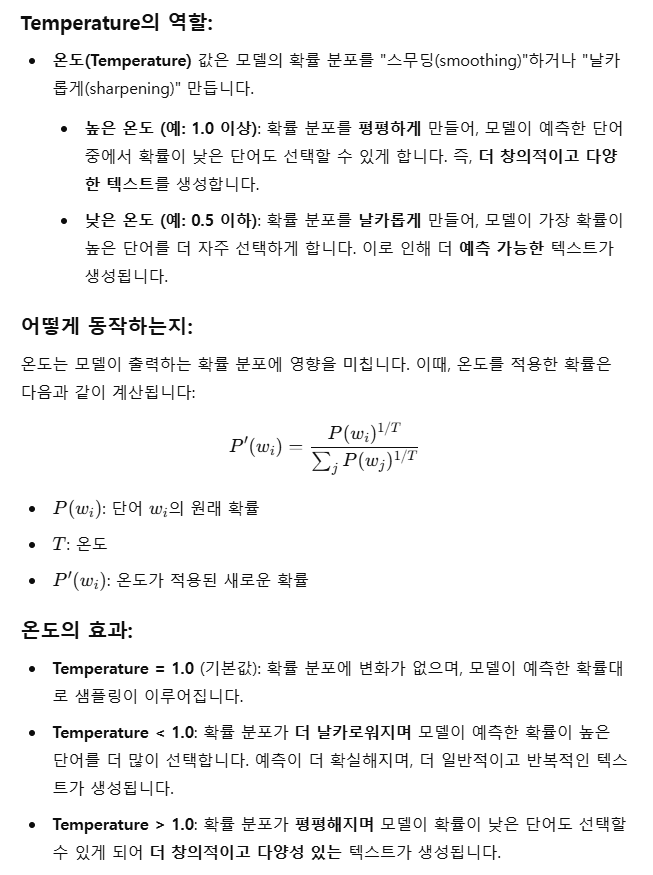

In [ ]:
# use temperature to decrease the sensitivity to low probability candidates
sample_output = model.generate(
    input_ids,
    do_sample=True,
    max_length=50,
    top_k=0,
    temperature=0.7 # temperature 설정
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output.tolist()[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
이순신은 조선 중기의 무신이다.</s><s> 로베르토 벅스칼 역</s><s> 로베르토 벅스칼 역()은 일본 오사카부 오사카 시에 있는 철도역이다.</s><s> 특급은 2면 2선 구조의 지상역이다.</s><s> 시부야 역


이제 이상한 n-gram이 적고 출력 문장이 조금 더 일관성 있게 생성됩니다. temperature를 적용하면 분포가 덜 랜덤하지만 `temperature` $ \to 0$,을 설정한다면 temperature가 적용된 sampling은 greedy decoding과 같아지며 이전과 동일한 문제를 겪습니다.

### **Top-K Sampling**

[Fan et. al (2018)](https://arxiv.org/pdf/1805.04833.pdf)

***Top-K*** sampling은 간단하지만 매우 강력한 생플링 방식을 도입했습니다. . *Top-K* sampling에서 가장 가능성 높은 다음 단어는 필터링 되고 확률 질량은 K 다음 단어에만 재분배됩니다. GPT2는 Top-K Sampling방식을 채택했는데, 이것이 Story Gerneration Task에 성공한 이유중 하나입니다.

Top-K Sampling을 더 잘 설명하기 위해 위의 예제에서 두 Sampling step에 사용되는 범위를 3단어에서 10단어로 확장합니다.

![top_k_sampling](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/top_k_sampling.png)


K=6을 설정하면 두 Sampling steps에서 Sampling pool을 6개의 단어로 제한합니다. $V_{\text{top-K}}$로 정의되는 가장 높은 6개의 단어로  sampling pool을 제한합니다.

첫 step에서 전체 확률 질량의 2/3인 0.68정도에 해당하는 단어에서 디코딩되지만, 두번째 step에서 거의 모든 확률질량인 0.99에서 디코딩합니다.

그럼에도 불구하고 그것이 두번째 sampling step에서 $\text{"not", "the", "small", "told"}$ 와 같은 다소 이상한 후보들을 성공적으로 제거가 가능했습니다.

In [ ]:
# set top_k to 50
# 확률 재조정: 선택된 K개의 단어들의 확률이 정규화(normalized) <- softmax를 통해 확률을 정규화
sample_output = model.generate(
    input_ids,
    do_sample=True,
    max_length=50,
    top_k=50    # top_k=50은 Top-K 샘플링을 활성화. 모델이 예측한 단어들 중에서 가장 확률이 높은 상위 50개의 단어들만 선택하고, 그 중에서 하나를 샘플링하여 다음 단어를 생성
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output.tolist()[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
이순신은 조선 중기의 무신이다.</s><s> (예시) 1세.</s><s> 2세 = 2세.</s><s> (예시)</s><s> (예시)</s><s> (예시)</s><s> (예시)</s><s>


나의 경우에는, 이상한 결과가 나옴.

지금까지 기법중 가장 인간적으로 보이는 텍스트를 생성했습니다. Top-K Sampling의 한 가지 우려되는 점은 다음 단어 확률 분포 $P(w|w_{1:t-1})$에서 필터링된 단어 수를 동적으로 조정하지 않는 점입니다. 예를들면 위 그림에서 첫번째 step의 단어들은 전반적으로 평평한 분포에서 Sampling 되지만, 두번째 step의 어떤 단어들은 매우 Sharp한 분포에서 Sampling 될 수 있기 때문에 문제가 될 수 있습니다.


Step $t=1$에서 Top-K은 꽤 합리적인 후보처럼 보이는 $\text{"people", "big", "house", "cat"}$을 샘플링하는 가능성을 배제합니다. 반면에 Step $t=2$에서 단어 Sample pool에 단어 $\text{"down", "a"}$와 같은 부적절한 단어를 포함합니다. 그러므로 Sample pool이 고정크기 K로 제한되면 모형이 Sharp한 분포에서 횡설수설한 단어를 고를 위험이있고 평평한 분포에서는 문장의 창의성이 제한될 수 있습니다. ([Ari Holtzman et al. (2019)](https://arxiv.org/abs/1904.09751))

### **Top-p (nucleus) sampling**

Top-p sampling은 가장 가능성 높은 단어 K 개에서만 Sample을 추출하는 방법이 아니라 누적확률이 확률 p를 초과하는 최소한의 단어 집합에서 Sample을 추출합니다.

그 후 확률 질량이 단어 집합 사이에 재분배 됩니다. 이 방법은 다음 단어의 확률 분포에 따라 단어 집합의 크기가 동적으로 증가하거나 감소할 수 있습니다.

![top_p_sampling](https://github.com/patrickvonplaten/scientific_images/blob/master/top_p_sampling.png?raw=true)



$p=0.92$을 설정할 경우, 상위 p Sample 추출은 $V_{\text{top-p}}$로 정의된 확률 질량의 $p=92\%$를 초과할 최소 단어 수를 선택합니다.
첫번째 예에서 가장 가능성 높은 9개의 단어 ("nice", "dog", "car" ...  house)가 포함된 반면, 두번째 예에서는 상위 3개의 단어("drives", "is", "turns")만 선택해도 92%를 초과하게 됩니다. 즉 높은 확률의 단어에만 Sampling 하고 그렇지 않은 단어는 Sampling할 확률이 매우 적습니다.

In [ ]:
# deactivate top_k sampling and sample only from 92% most likely words
sample_output = model.generate(
    input_ids,
    do_sample=True,
    max_length=50,
    top_p=0.92, # 모델이 확률 분포에서 상위 92%에 해당하는 단어들만 고려하도록 설정. 즉, 각 확률 값이 큰 단어들을 순서대로 정렬한 후, 그들의 누적 확률이 92%에 도달할 때까지 단어들을 선택
    top_k=0
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output.tolist()[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
이순신은 조선 중기의 무신이다.</s><s> 놀란 눈을 가진 해피아는 사고를 터득하고 위기관리능력으로 남자들을 사로잡는다.</s><s> 8일 중구 대광고에서 열린 영화 '아이언맨3'(감독 셰인 로먼)제작


이론적으로는 Top-p가 Top-K보다 더 성능이 좋아 보이지만, 두 방법 모두 실제로 잘 작동합니다. Top-p는 또한 Top-K와 함께 사용될 수 있는데, 이것은 매우 낮은 순위의 단어를 피하면서도 일부 동적 선택을 허용할 수 있습니다.

독립적으로 샘플링된 다중 출력을 얻기 위하여 파라미터를 다시 설정하도록 코드를 구성 할 수도 있습니다. `num_return_sequences > 1`:

In [ ]:
# set top_k = 50 and set top_p = 0.95 and num_return_sequences = 3
sample_outputs = model.generate(
    input_ids,
    do_sample=True,
    max_length=50,
    top_k=20,
    top_p=0.90,
    num_return_sequences=3  # 주어진 입력에 대해 3개의 서로 다른 텍스트를 생성
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output.tolist(), skip_special_tokens=True)))

Output:
----------------------------------------------------------------------------------------------------
0: 이순신은 조선 중기의 무신이다.</s><s> "나는 한없이 작은 사람"이라고 밝힌 그는 "그에 대한 나의 감정과는 별개로 나는 다른 사람들과 함께 있을 수 있다는 것 자체에 대해 나는 감사하고 있다"고 덧붙였다.</s><s> 또한 그는 "
1: 이순신은 조선 중기의 무신이다.</s><s> 그러나 이 같은 상황은 10년 만에 찾아온 '마이너스 위기'에 가깝다.</s><s> 이 와중에 지난 10년 간 미국 경제의 '잃어버린 10년'과 '재정절벽'이 미국을 더
2: 이순신은 조선 중기의 무신이다.</s><s> 그러나 이 또한 ‘귀하신 몸’이라는 것을 잘 설명해주지는 않는다.</s><s> 다만 그 존재는 ‘자신과 다른 것’이라는 것을 이해해주면 좋다.</s><s> 즉 자신의 몸을 ‘


### **Analysis**


모델을 돌리고 분석한 점을 자유롭게 적어주세요!

Your Opinion: 생각보다 한국어에서의 성능이 좋지 않다는 것을 알았고, 확률을 기반한 단어 생성으로 인해, 문법적으로 문장은 자연스러울 수 있으나, 실제 사실을 얘기하지 못한다는 것을 알 수 있다. 즉, 할루시네이션(Hallucination) 문제에 자유롭지 못하다고 할 수 있다.

### **Conclusion**

GPT를 포함한 생성형 언어모델을 활용하면서 중요하다 느낀 점들을 자유롭게 적어주세요!

Your Opinion: 단순 확률이 높은 단어를 생성하는 것이 항상 좋은 것이 아님을 알 수 있었다. 또한, Beamsearch의 설명과 같이, 모델은 확률 기반으로 문장을 만들어내기에 예측 가능한 문장만을 생성하지만, 인간은 예측할 수 없는 놀라운 문장들도 만들어낸다는 점에서, 아직 NLP 분야는 발전해나갈 부분이 많다고 생각한다.

해당 부분을 보완하기 위해, 강화학습 기법 및 RAG와 같은 여러 기술들이 반드시 필요하다고 생각한다.


### **References**

*   ([Welleck et al. (2020)](https://arxiv.org/abs/2002.02492))
*   ([Welleck et al. (2019)](https://arxiv.org/pdf/1908.04319.pdf))